In [12]:
# import sys
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install qiskit
# !{sys.executable} -m pip install qiskit_machine_learning
# !{sys.executable} -m pip install pylatexenc

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  preprocessing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from qiskit import providers
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [14]:
df = pd.read_csv('titanic_dataset/train.csv') # read csv file as pandas data frame
df.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [15]:
feature_name_list = list(df)
list(feature_name_list)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [16]:
df_selected = df[[ 'Pclass', 'Survived','Age', 'Sex', 'Parch']] # Choose desired features and labels(classes)
df_selected

,Pclass,Survived,Age,Sex,Parch
0,3,0,22.0,male,0
1,1,1,38.0,female,0
2,3,1,26.0,female,0
3,1,1,35.0,female,0
4,3,0,35.0,male,0
...,...,...,...,...,...
886,2,0,27.0,male,0
887,1,1,19.0,female,0
888,3,0,NaN,female,2
889,1,1,26.0,male,0


In [17]:
print('Total empty values in the Dataset :', df_selected.isnull().sum().sum())
clean_data = df_selected.dropna()
#print('Total empty values in the Dataset :', clean_data.isnull().sum().sum())

Total empty values in the Dataset : 177


In [18]:
for col in clean_data.columns:
        print('Unique values in {} :'.format(col),len(clean_data[col].unique()))

Unique values in Pclass : 3
Unique values in Survived : 2
Unique values in Age : 88
Unique values in Sex : 2
Unique values in Parch : 7


In [19]:
clean_data

,Pclass,Survived,Age,Sex,Parch
0,3,0,22.0,male,0
1,1,1,38.0,female,0
2,3,1,26.0,female,0
3,1,1,35.0,female,0
4,3,0,35.0,male,0
...,...,...,...,...,...
885,3,0,39.0,female,5
886,2,0,27.0,male,0
887,1,1,19.0,female,0
889,1,1,26.0,male,0


In [20]:
print('Unique values in updated Gender column :', clean_data.Sex.unique())
print('Range of column Age :', (clean_data.Age.min(), clean_data.Age.max()))
print('Unique values in parent/child column :', clean_data.Parch.unique())
print('Unique values in passenger class column :', clean_data.Pclass.unique())

clean_data['Sex'].replace(to_replace = 'male', value = 0, inplace=True)
clean_data['Sex'].replace(to_replace = 'female', value = 1, inplace=True)

Unique values in updated Gender column : ['male' 'female']
Range of column Age : (0.42, 80.0)
Unique values in parent/child column : [0 1 2 5 3 4 6]
Unique values in passenger class column : [3 1 2]


In [21]:
# Define features and labels (that contin class information)
test_ratio = 0.2
seed = 1438
np.random.seed(seed)
x_original = np.array(clean_data.drop('Survived', axis =1)) # X contains all feature values as array
y = np.array(clean_data.Survived) # y contains class values as array
x = preprocessing.normalize(x_original, axis=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=seed, stratify=y)

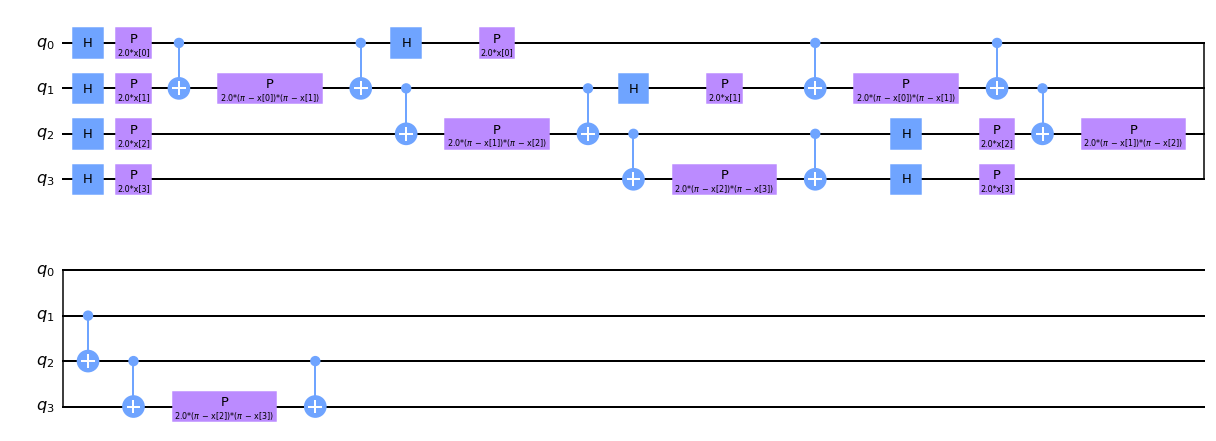

In [22]:
feature_dim = x.shape[1]
feature_map_rep = 2
ent = 'linear'

fmap_zz = ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)
fmap_zz.decompose().draw('mpl', scale=1)

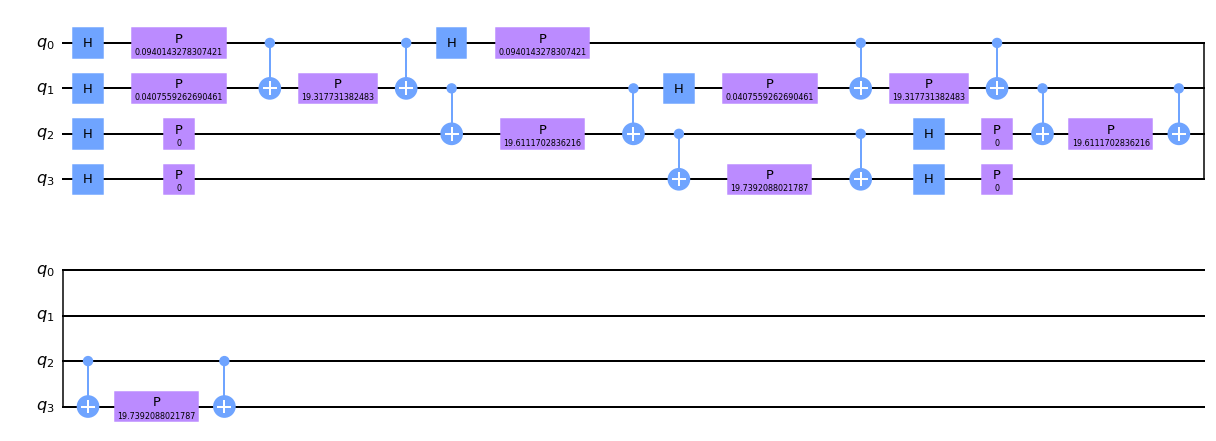

In [23]:
fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

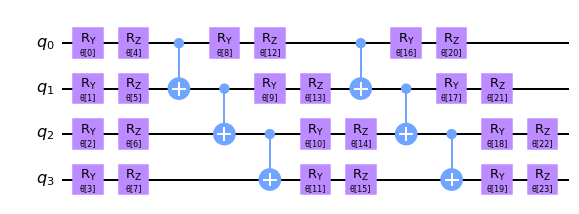

In [24]:
rotations = ['ry', 'rz']
var_form_rep = 2


ansatz_tl = TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)
ansatz_tl.decompose().draw('mpl', scale=1)

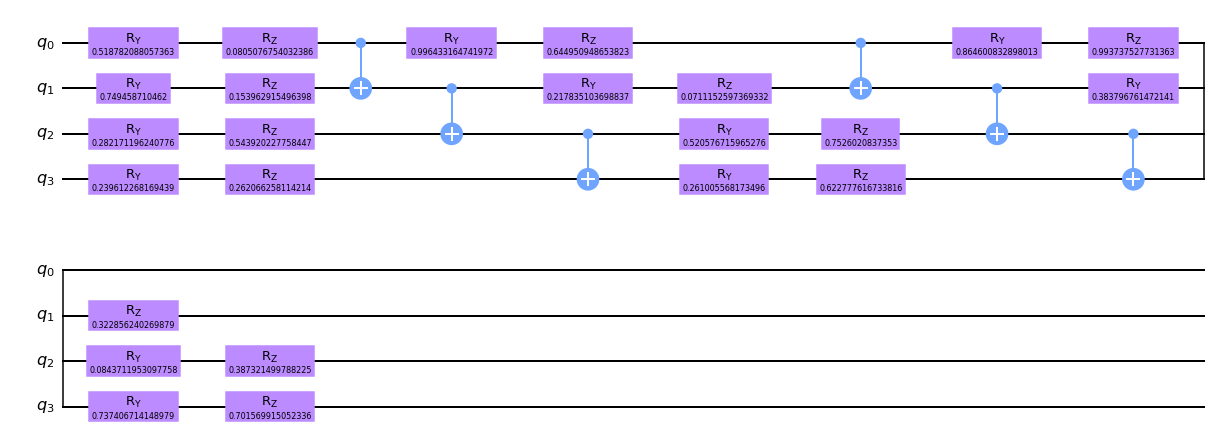

In [25]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=1)

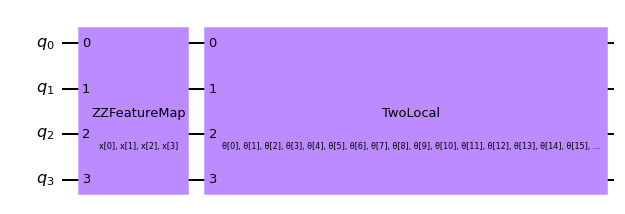

In [26]:
var_circuit = fmap_zz.compose(ansatz_tl)
var_circuit.draw('mpl')

In [27]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [28]:
# providers.aer.StatevectorSimulator().available_devices()

In [29]:
# statevec_sim = providers.aer.StatevectorSimulator(max_parallel_threads = 16, max_parallel_experiments=0)

In [30]:
qasm_sim = Aer.get_backend('qasm_simulator')
qinst = QuantumInstance(qasm_sim, 2048, seed_simulator=seed)

In [31]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [32]:
# The result of the neural network of the shape (output_shape).
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.30566406, 0.69433594]])

In [33]:
# The result of the neural network of the backward pass, i.e., a tuple with the gradients
# for input and weights of shape (output_shape, num_input) and
# (output_shape, num_weights), respectively.
_, update = qnn.backward(x_train[0], weights)
update

array([[[-9.37500000e-02,  1.73339844e-02, -5.10253906e-02,
          3.41796875e-03, -4.10156250e-02,  4.76074219e-02,
          1.14013672e-01,  7.81250000e-03, -3.03222656e-01,
         -1.25976562e-01,  1.34277344e-02, -1.73472348e-18,
          5.41992187e-02,  3.68652344e-02, -7.56835937e-03,
          1.04980469e-02, -1.85791016e-01,  2.68554687e-03,
         -1.14746094e-02, -5.12695313e-03, -3.41796875e-03,
         -9.76562500e-04, -4.63867187e-03,  1.92871094e-02],
        [ 9.37500000e-02, -1.73339844e-02,  5.10253906e-02,
         -3.41796875e-03,  4.10156250e-02, -4.76074219e-02,
         -1.14013672e-01, -7.81250000e-03,  3.03222656e-01,
          1.25976562e-01, -1.34277344e-02,  5.20417043e-17,
         -5.41992188e-02, -3.68652344e-02,  7.56835938e-03,
         -1.04980469e-02,  1.85791016e-01, -2.68554687e-03,
          1.14746094e-02,  5.12695313e-03,  3.41796875e-03,
          9.76562500e-04,  4.63867187e-03, -1.92871094e-02]]])

In [34]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [35]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [36]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


# x_train_norm = np.array([x/np.linalg.norm(x) for x in x_train])
# x_test_norm = np.array([x/np.linalg.norm(x) for x in x_test])

vqc = vqc.fit(x_train, y_train_1h)

3 - 519.1936603621945
6 - 531.5554437391079
9 - 533.8462993171595
12 - 544.8243596078854
15 - 571.2512619279385
18 - 705.2690890727699
21 - 787.7076259850501
24 - 639.8050638925356
27 - 541.3930752527574
30 - 541.017220046071
33 - 678.0496756664155
36 - 575.7165491182964
39 - 559.4170155778847
42 - 559.3087034017842
45 - 557.9879508528918
48 - 558.3786641979176
51 - 556.7182672892059
54 - 555.7176779178062
57 - 553.3413129082628
60 - 553.6339224024368
63 - 548.0110858733802
66 - 546.3661304617771
69 - 551.9887178239273
72 - 551.2742425476642
75 - 543.4988184014871
78 - 542.283428166269
81 - 541.7393036212576
84 - 541.671545198098
87 - 539.8228853522653
90 - 539.6916990112079
93 - 538.2202083287581
96 - 537.9157431857627
99 - 537.5155396067225
102 - 537.2129866914177
105 - 537.3437967300765
108 - 537.4675849815363
111 - 537.6117306329502
114 - 537.1838836721715
117 - 536.0928242126568
120 - 535.438522017872
123 - 535.5741017242594
126 - 535.3237629757894
129 - 533.891996961499
132 - 533

In [37]:
score_train = vqc.score(x_train, y_train_1h)
score_test = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.7880910683012259
Score on the test set 0.7132867132867133


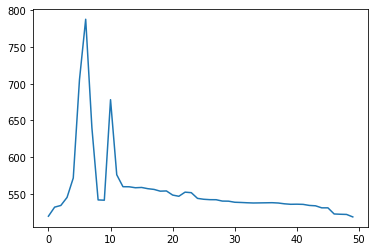

In [38]:
plt.plot(loss_recorder)